# Sentiment Analysis on Amazon Review Dataset

In this notebook we will be doing some sentiment analysis in python using the different techniques:

* VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
* Roberta Pretrained Model from Hugging face trained using Tweeter dataset

# Data Ingestion
Let's start by loading the dataset. For this task, we'll be using the Amazon Fine Food Reviews dataset.

We'll download the dataset from the official website and load it into a pandas dataframe.

Please note that this dataset is quite large and might take some time to download.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import nltk
from wordcloud import WordCloud

In [2]:
# Read the dataset
data = pd.read_csv('amazon_reviews.csv.zip', compression='zip')

# Display first few rows of the dataset
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## Simple EDA


Let's do some basic EDA to understand the distribution of scores and the length of reviews.
First create some features and then analysis

**Distribution of Ratings (Score)**

**Score Distribution**

The distribution of scores is as follows:

* 1-2: Negative
* 3: Neutral
* 4-5: Positive

**Review Length Distribution**

**Sentiment Analysis**

**Review Length vs. Ratings**

**Sentiment vs. Ratings**

**Most Frequent Words in Review (WordCloud)**

In [4]:
# Now let's look at the review lengths and filter only lenth up to 500 words.
cols = ['Id', 'Score', 'Text']
df =(data
    .loc[:, cols]
    .assign(review_length = data['Text'].apply(lambda x: len(x.split())),
            sentiment = pd.cut(data["Score"],
            bins=[0, 2, 3, 5],
            labels=['Negative', 'Neutral', 'Positive'],
            right=True
            )
        )
    .rename(columns = {'Score': "Ratings"})
    .rename(columns=str.lower)
    .loc[lambda x: x['review_length'] <= 500]
    .reset_index(drop=True)
)
 


In [5]:
df.head()

,id,ratings,text,review_length,sentiment
0,1,5,I have bought several of the Vitality canned d...,48,Positive
1,2,1,Product arrived labeled as Jumbo Salted Peanut...,31,Negative
2,3,4,This is a confection that has been around a fe...,94,Positive
3,4,2,If you are looking for the secret ingredient i...,41,Negative
4,5,5,Great taffy at a great price. There was a wid...,27,Positive


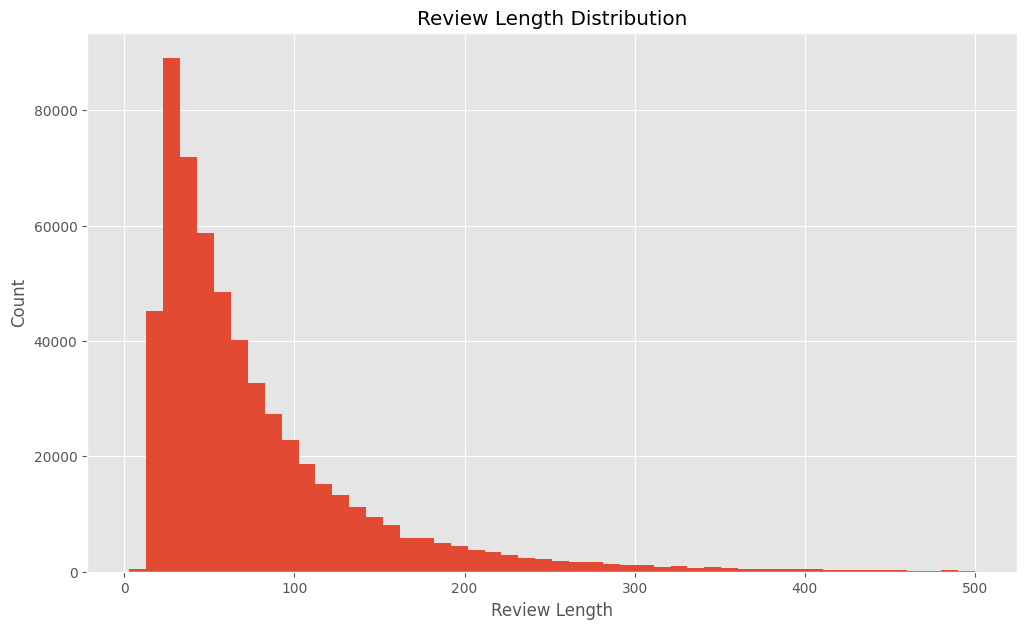

In [6]:
# Review Length Distribution
ax = df['review_length'].plot(kind='hist', bins=50, figsize=(12, 7), title="Review Length Distribution")
ax.set_xlabel("Review Length")
ax.set_ylabel("Count")  
plt.show()

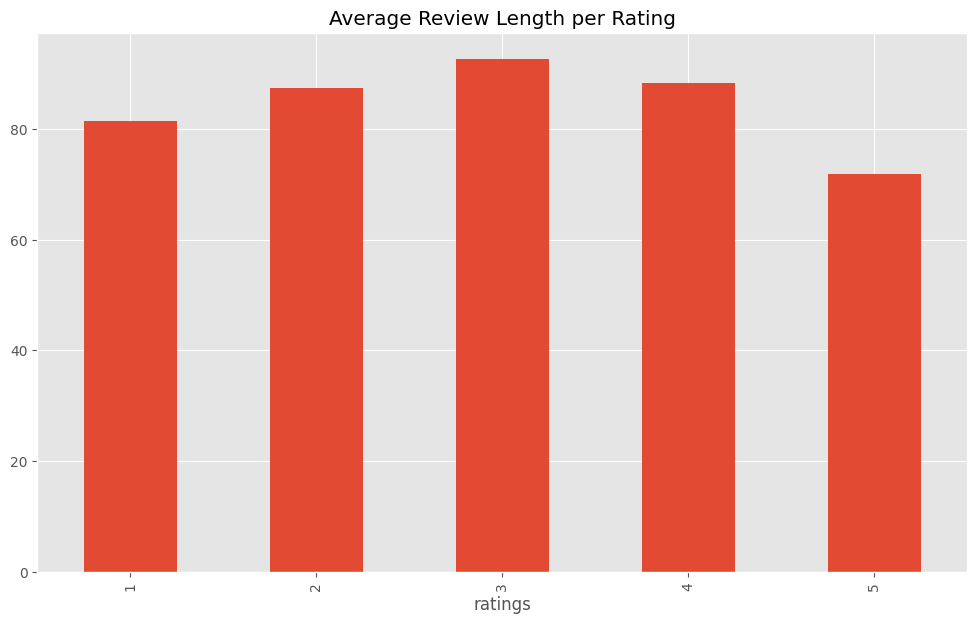

In [7]:
# Let's look at the average review length for each score.

avg_review_length = df.groupby('ratings')['review_length'].mean()
avg_review_length.plot(kind='bar', figsize=(12, 7), title="Average Review Length per Rating")
ax.set_xlabel("Review Ratings")
ax.set_ylabel("Average Review Length")
plt.show() 

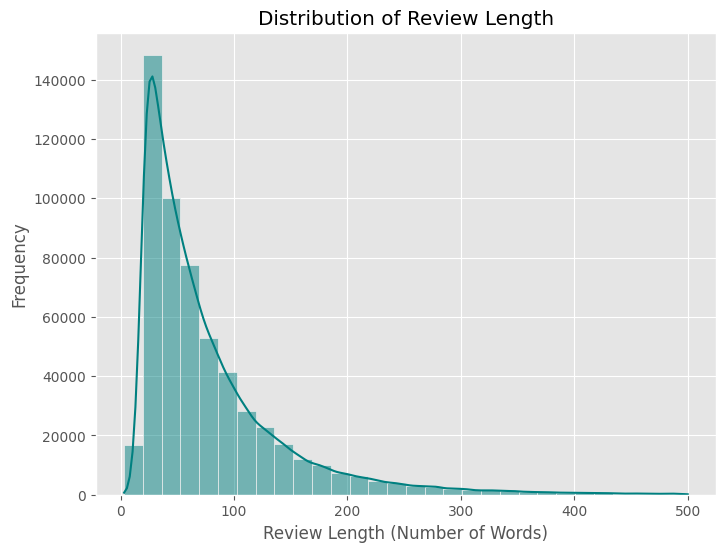

In [8]:
plt.figure(figsize=(8, 6))
sns.histplot(df['review_length'], bins=30, kde=True, color='teal')
plt.title('Distribution of Review Length')
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()


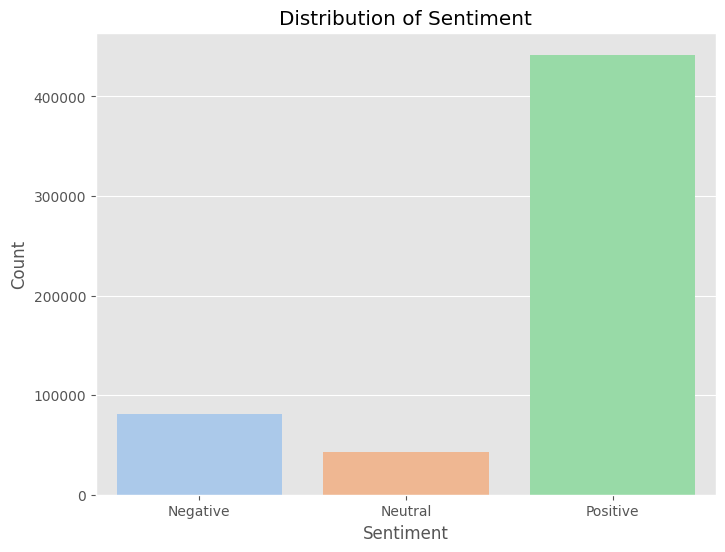

In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', hue='sentiment', legend=False, data=df, palette='pastel')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


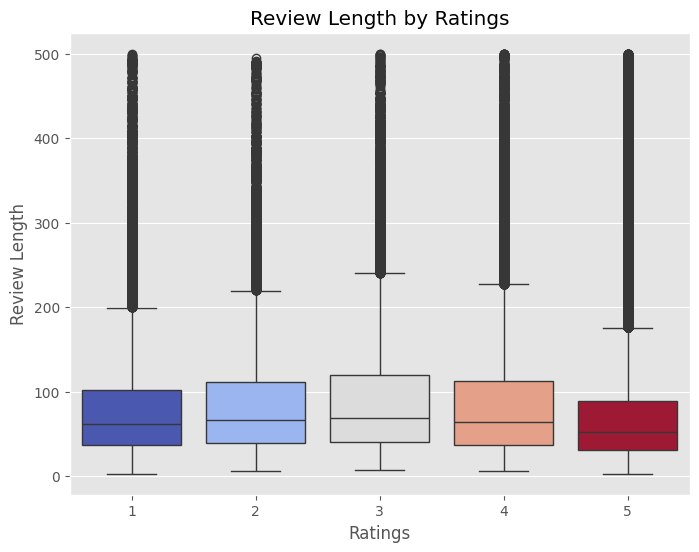

In [10]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='ratings', y='review_length', hue='ratings', legend=False, data=df, palette='coolwarm')
plt.title('Review Length by Ratings')
plt.xlabel('Ratings')
plt.ylabel('Review Length')
plt.show()


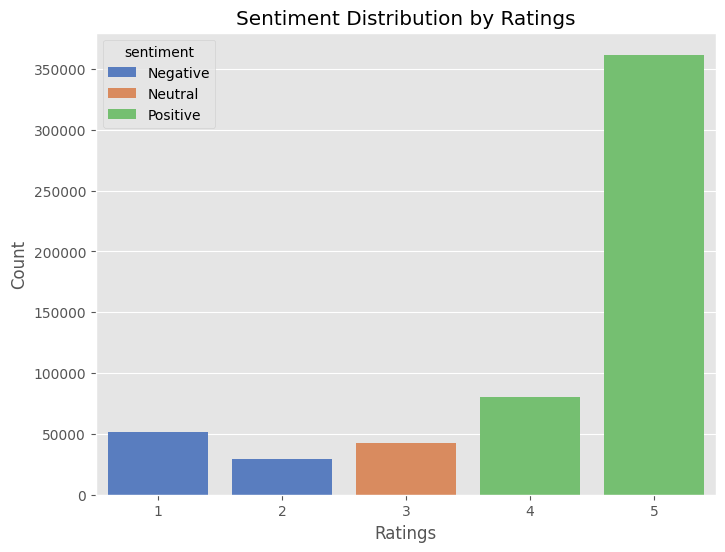

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(x='ratings', hue='sentiment', data=df, palette='muted')
plt.title('Sentiment Distribution by Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()


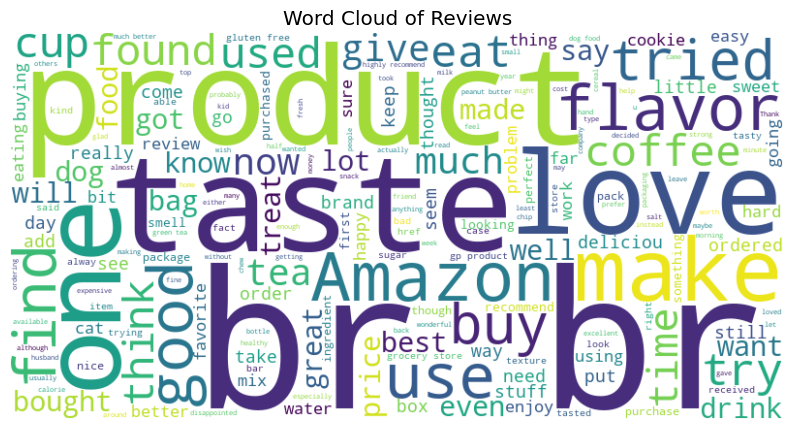

In [12]:


# Generate word cloud
text_data = " ".join(review for review in df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Reviews')
plt.axis('off')
plt.show()


## NLTK

We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.


* This uses a "bag of words" approach:

1. Stop words are removed

2. each word is scored and combined to a total score.


In [13]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
#from tqdm import tqdm


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/donadviser/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [14]:
sia = SentimentIntensityAnalyzer()

In [15]:
# example
sia.polarity_scores('It has been a mixed feelings today, however, I will say so far so good')

{'neg': 0.0, 'neu': 0.747, 'pos': 0.253, 'compound': 0.6213}

In [16]:
!pip install ipywidgets


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [17]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
/Users/donadviser/.pyenv/versions/3.11.9/envs/venv311_nlp/lib/python3.11/site-packages/jupyterlab/debuglog.py:54: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
/Users/donadviser/.pyenv/versions/3.11.9/envs/venv311_nlp/lib/python3.11/site-packages/jupyterlab/debuglog.py:55: UserWarning: ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
  warnings.warn(msg[-1].strip())
/Users/donadviser/.pyenv/versions/3.11.9/envs/venv311_nlp/lib/python3.11/site-packages/jupyterlab/debuglog.py:56: U

In [18]:
!pip install --upgrade jupyterlab


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [19]:
import ipywidgets as widgets
widgets.IntSlider()

IntSlider(value=0)

In [20]:
from tqdm import tqdm

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['text']
        # Your processing code here
    except Exception as e:
        print(f"Error processing row {i}: {e}")

100%|██████████| 565848/565848 [00:07<00:00, 77803.86it/s]


In [21]:
!pip install --upgrade tqdm ipywidgets



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [22]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['text']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

100%|██████████| 565848/565848 [03:40<00:00, 2565.51it/s]


In [23]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(df, how='left')

In [24]:
# Now we have sentiment score and metadata
vaders.head()

,id,neg,neu,pos,compound,ratings,text,review_length,sentiment
0,1,0.000,0.695,0.305,0.9441,5,I have bought several of the Vitality canned d...,48,Positive
1,2,0.138,0.862,0.000,-0.5664,1,Product arrived labeled as Jumbo Salted Peanut...,31,Negative
2,3,0.091,0.754,0.155,0.8265,4,This is a confection that has been around a fe...,94,Positive
3,4,0.000,1.000,0.000,0.0000,2,If you are looking for the secret ingredient i...,41,Negative
4,5,0.000,0.552,0.448,0.9468,5,Great taffy at a great price. There was a wid...,27,Positive


## Visualise the VADER Results

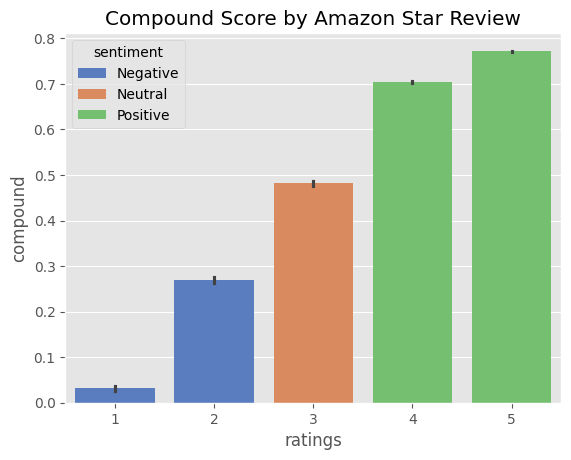

In [25]:
ax = sns.barplot(data=vaders, x='ratings', y='compound', hue='sentiment', legend=True, palette='muted')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

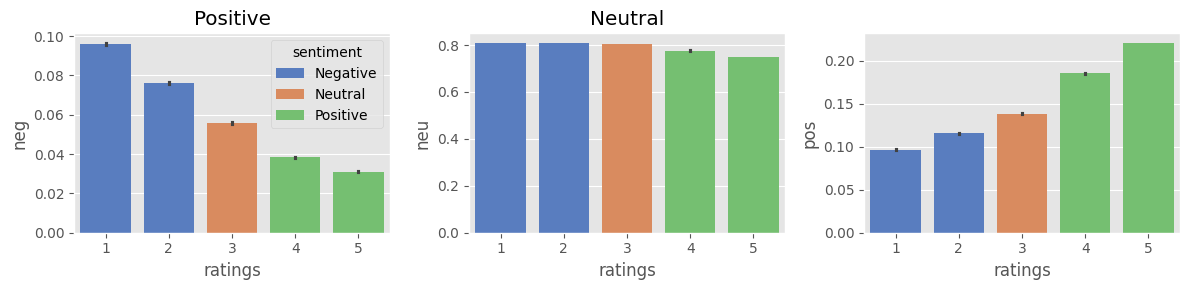

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='ratings', y='neg', ax=axs[0], hue='sentiment', legend=True, palette='muted')
sns.barplot(data=vaders, x='ratings', y='neu', ax=axs[1], hue='sentiment', legend=False, palette='muted')
sns.barplot(data=vaders, x='ratings', y='pos', ax=axs[2], hue='sentiment', legend=False, palette='muted')
axs[0].set_title('Negative')
axs[1].set_title('Neutral')
axs[0].set_title('Positive')

plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model¶

This is a RoBERTa-base model trained on ~124M tweets from January 2018 to December 2021, and finetuned for sentiment analysis with the TweetEval benchmark. 


* Use a model trained of a large corpus of data.
* Transformer model accounts for the words but also the context related to other words.

In [27]:
!pip install transformers
!pip install scipy



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [28]:
from transformers import AutoTokenizer, AutoConfig
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [29]:
!pip install torch torchvision torchaudio
import torch



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [30]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/Users/donadviser/.pyenv/versions/3.11.9/envs/venv311_nlp/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpo

In [31]:
text = "As a property owner, house rents are increasing fast!"
#text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [32]:
scores

array([0.40190658, 0.48353288, 0.1145605 ], dtype=float32)

In [33]:
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) neutral 0.4835
2) negative 0.4019
3) positive 0.1146


In [34]:
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': np.float32(0.40190658), 'roberta_neu': np.float32(0.48353288), 'roberta_pos': np.float32(0.1145605)}


In [35]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [37]:
res = {}
df_sample = df.head(10000)
for i, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    try:
        text = row['text']
        myid = row['id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  1%|          | 84/10000 [00:05<11:41, 14.14it/s]

Broke for id 83


  2%|▏         | 189/10000 [00:11<09:37, 16.99it/s]

Broke for id 187


  7%|▋         | 743/10000 [00:49<11:51, 13.01it/s]

Broke for id 746


  9%|▊         | 863/10000 [00:57<08:21, 18.24it/s]

Broke for id 863


 11%|█         | 1068/10000 [01:12<09:02, 16.46it/s]

Broke for id 1070


 12%|█▏        | 1156/10000 [01:18<08:37, 17.10it/s]

Broke for id 1156


 14%|█▎        | 1373/10000 [01:32<10:03, 14.29it/s]

Broke for id 1375


 16%|█▌        | 1571/10000 [01:47<10:42, 13.11it/s]

Broke for id 1575


 18%|█▊        | 1794/10000 [02:02<07:57, 17.18it/s]

Broke for id 1796


 22%|██▏       | 2165/10000 [02:29<08:14, 15.85it/s]

Broke for id 2169


 22%|██▏       | 2243/10000 [02:34<08:05, 15.97it/s]

Broke for id 2248


 25%|██▍       | 2472/10000 [02:51<08:20, 15.06it/s]

Broke for id 2476


 29%|██▉       | 2889/10000 [03:21<07:42, 15.39it/s]

Broke for id 2897


 29%|██▉       | 2893/10000 [03:21<07:34, 15.64it/s]

Broke for id 2902


 29%|██▉       | 2934/10000 [03:24<07:43, 15.24it/s]

Broke for id 2944
Broke for id 2947


 38%|███▊      | 3773/10000 [04:23<06:07, 16.94it/s]

Broke for id 3788


 40%|███▉      | 3954/10000 [04:36<05:34, 18.05it/s]

Broke for id 3969


 41%|████      | 4092/10000 [04:47<06:57, 14.16it/s]

Broke for id 4107
Broke for id 4110


 45%|████▍     | 4464/10000 [05:15<04:44, 19.45it/s]

Broke for id 4483


 45%|████▍     | 4493/10000 [05:18<06:08, 14.94it/s]

Broke for id 4512


 45%|████▌     | 4534/10000 [05:21<05:43, 15.89it/s]

Broke for id 4553


 50%|█████     | 5022/10000 [05:57<05:11, 15.99it/s]

Broke for id 5040


 52%|█████▏    | 5163/10000 [06:07<05:05, 15.82it/s]

Broke for id 5182


 52%|█████▏    | 5172/10000 [06:08<05:39, 14.24it/s]

Broke for id 5192


 60%|█████▉    | 5980/10000 [07:11<04:25, 15.14it/s]

Broke for id 6003


 60%|█████▉    | 5982/10000 [07:11<04:46, 14.00it/s]

Broke for id 6007


 61%|██████    | 6083/10000 [07:19<04:22, 14.94it/s]

Broke for id 6106


 65%|██████▌   | 6534/10000 [07:55<04:46, 12.11it/s]

Broke for id 6558


 66%|██████▋   | 6626/10000 [08:02<05:03, 11.12it/s]

Broke for id 6651


 68%|██████▊   | 6773/10000 [08:16<04:53, 10.98it/s]

Broke for id 6798


 68%|██████▊   | 6811/10000 [08:20<04:52, 10.89it/s]

Broke for id 6838


 69%|██████▊   | 6860/10000 [08:24<03:17, 15.88it/s]

Broke for id 6886


 69%|██████▉   | 6880/10000 [08:26<04:03, 12.82it/s]

Broke for id 6905


 69%|██████▉   | 6930/10000 [08:30<04:01, 12.70it/s]

Broke for id 6955


 71%|███████   | 7052/10000 [08:38<03:36, 13.61it/s]

Broke for id 7077


 71%|███████   | 7062/10000 [08:39<03:14, 15.09it/s]

Broke for id 7088


 72%|███████▏  | 7177/10000 [08:47<02:55, 16.08it/s]

Broke for id 7201


 76%|███████▌  | 7579/10000 [09:18<02:49, 14.30it/s]

Broke for id 7604


 76%|███████▋  | 7644/10000 [09:22<02:25, 16.16it/s]

Broke for id 7671


 77%|███████▋  | 7675/10000 [09:25<02:44, 14.17it/s]

Broke for id 7701


 81%|████████  | 8101/10000 [09:57<02:13, 14.25it/s]

Broke for id 8131


 82%|████████▏ | 8237/10000 [10:08<01:55, 15.24it/s]

Broke for id 8266


 87%|████████▋ | 8710/10000 [10:44<01:30, 14.31it/s]

Broke for id 8740


 89%|████████▉ | 8905/10000 [10:58<01:01, 17.80it/s]

Broke for id 8935


 96%|█████████▌| 9560/10000 [11:45<00:30, 14.39it/s]

Broke for id 9590


 99%|█████████▉| 9878/10000 [12:09<00:09, 12.84it/s]

Broke for id 9910


 99%|█████████▉| 9891/10000 [12:10<00:08, 13.55it/s]

Broke for id 9923


100%|█████████▉| 9970/10000 [12:16<00:02, 13.81it/s]

Broke for id 10002


100%|█████████▉| 9997/10000 [12:18<00:00, 15.33it/s]

Broke for id 10031


100%|██████████| 10000/10000 [12:18<00:00, 13.55it/s]


In [38]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(df, how='left')

## Compare Scores between models¶

In [39]:
results_df.columns


Index(['id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ratings', 'text',
       'review_length', 'sentiment'],
      dtype='object')

# Step 3. Combine and compare¶


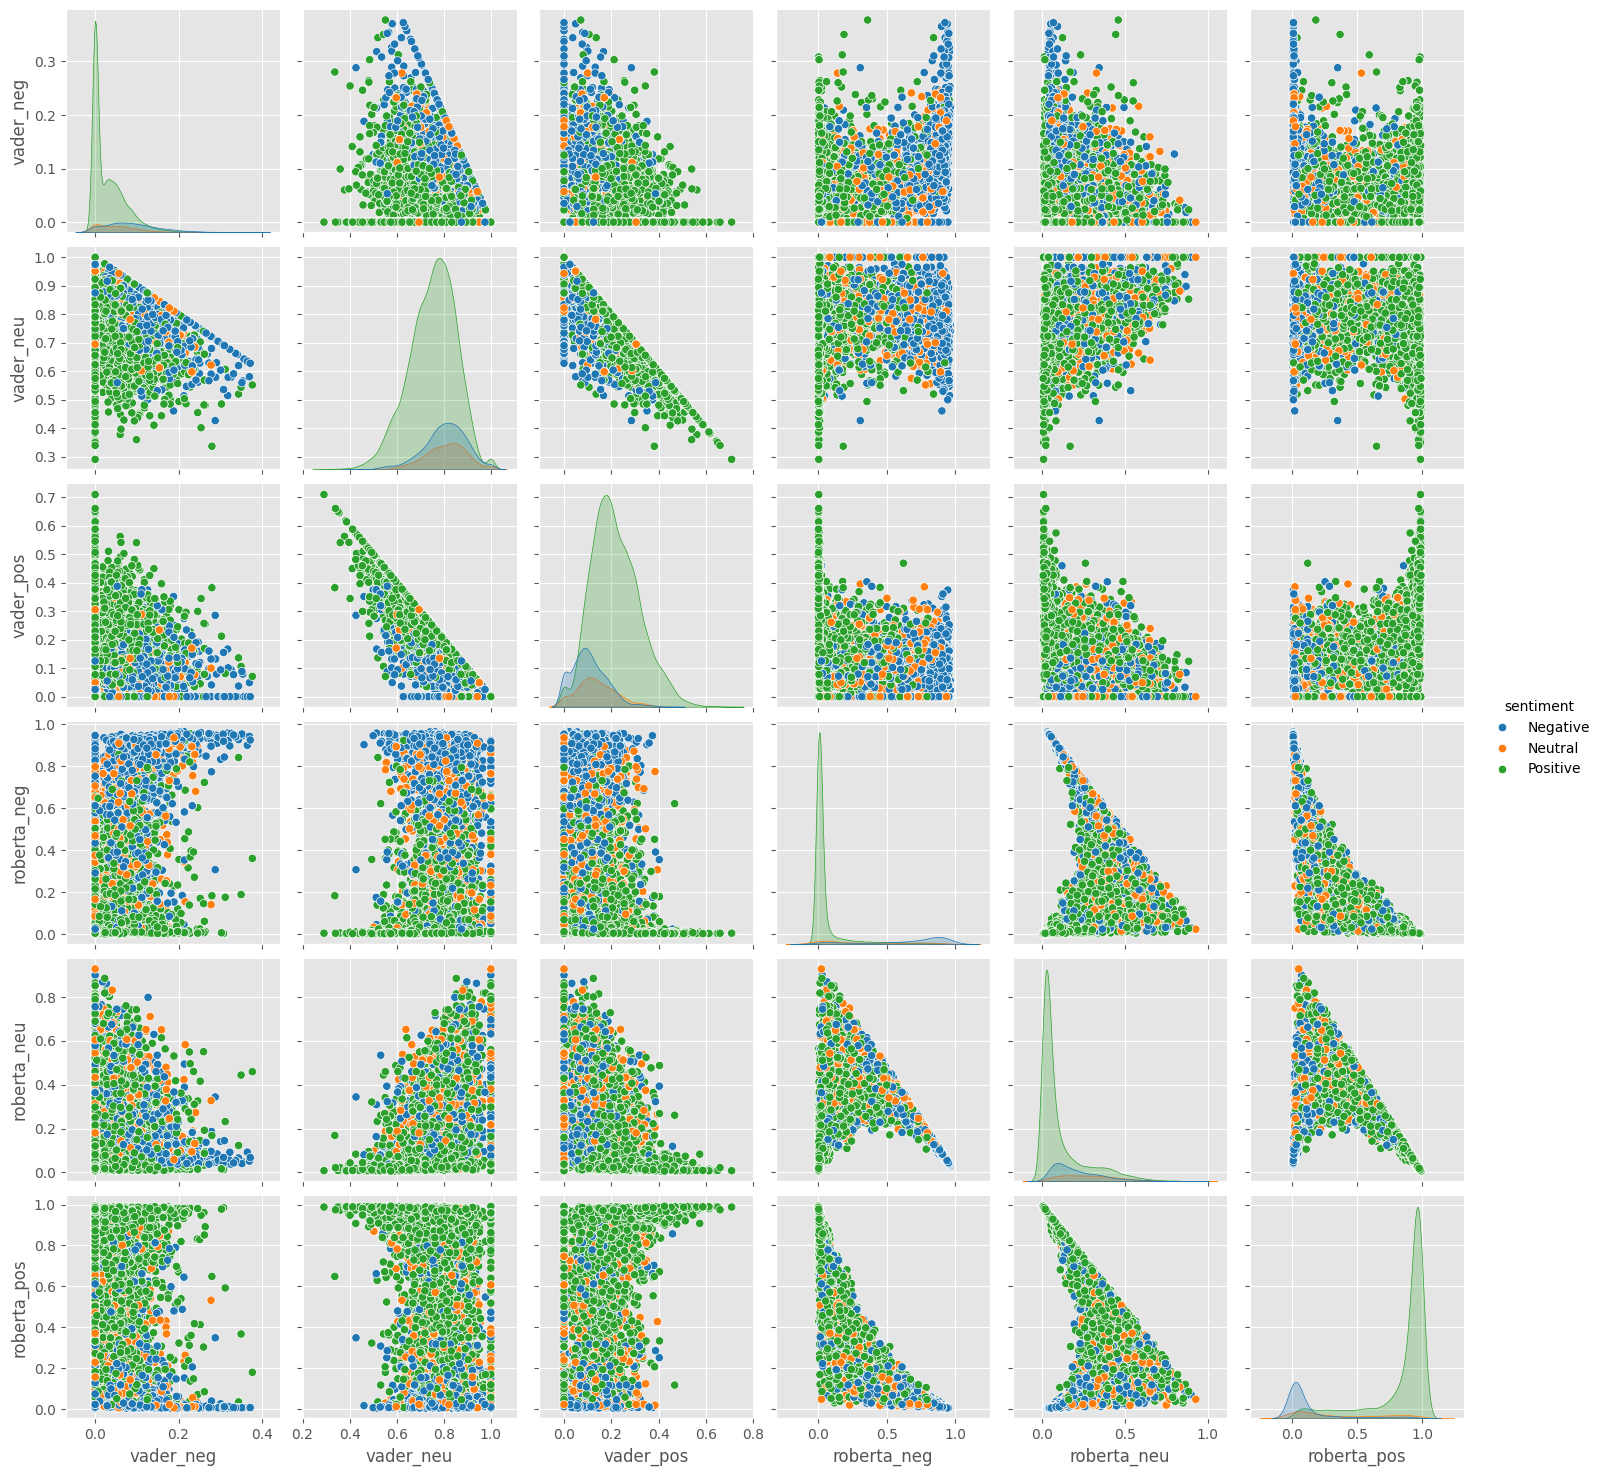

In [41]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='sentiment',
            palette='tab10')
plt.show()


#  Step 4: Review Examples:¶

* Positive 1-Star and Negative 5-Star Reviews


Lets look at some examples where the model scoring and review score differ the most.

In [43]:
results_df.query('ratings == 1') \
    .sort_values('roberta_pos', ascending=False)['text'].values[0]

'Bisquick GF is easy to use. Pancakes and muffins are very<br />tasty. The product is quick and easy to use. It makes my day.  Gram'

In [44]:
results_df.query('ratings == 1') \
    .sort_values('vader_pos', ascending=False)['text'].values[0]

'This flavor is horrible.  There are many other flavors much better.  Hawaiian Hazelnut is great!  Breakfast in Bed is AWesome!'

* Negative sentiment 5-Star view

In [45]:
results_df.query('ratings == 5') \
    .sort_values('roberta_neg', ascending=False)['text'].values[0]

'They have a bad taste,i finish giving them away because my son started to cry everytime i tried to give these.I prefer Beech nut or Gerber.Yuck!'

In [46]:
results_df.query('ratings == 5') \
    .sort_values('vader_neg', ascending=False)['text'].values[0]

'My two cats must not be interested in grass, because it grew but they ignored it. Had no problems growing it.'

# Extra: The Transformers Pipeline¶

* Quick & easy way to run sentiment predictions

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")